## Passband QAM with IQ modulation and demodulation

### Passband QAM signals

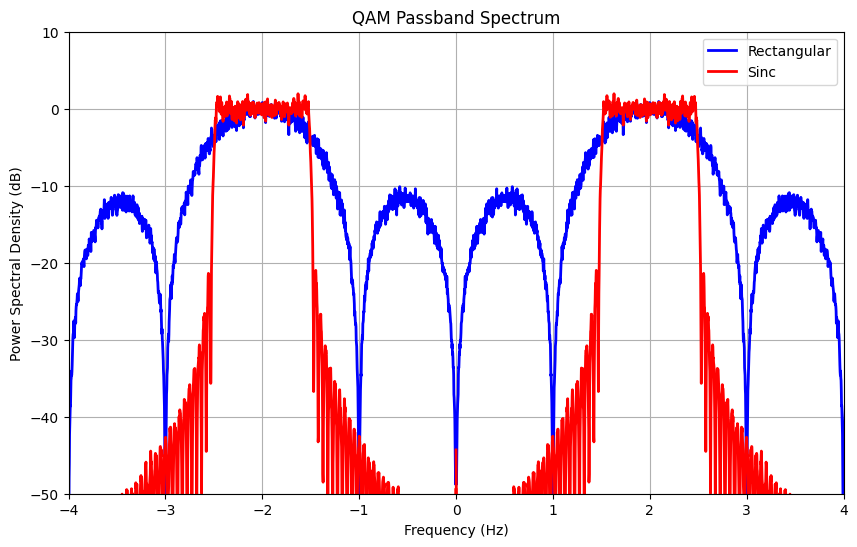

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, convolve

# Parameters
N = 10**4  # Number of symbols
fs = 10    # Samples per symbol
fc = 2     # Carrier frequency

# Generate QAM symbols (using PAM-4 for I and Q)
bits_i = np.random.randint(0, 4, N)
bits_q = np.random.randint(0, 4, N)

# Map to PAM-4 levels and normalize
am_i = (2 * bits_i - 3) / np.sqrt(5)  # I component
am_q = (2 * bits_q - 3) / np.sqrt(5)  # Q component

# Upsample
am_i_upsampled = np.zeros(N * fs)
am_q_upsampled = np.zeros(N * fs)
am_i_upsampled[::fs] = am_i
am_q_upsampled[::fs] = am_q

# Pulse shaping filter
gt_rectangular = np.ones(fs)
t = np.arange(-fs, fs + 1/fs, 1/fs)
gt_sinc = np.sinc(t)

# Filter I and Q components
si_rectangular = convolve(am_i_upsampled, gt_rectangular, mode='full')
sq_rectangular = convolve(am_q_upsampled, gt_rectangular, mode='full')
si_sinc = convolve(am_i_upsampled, gt_sinc, mode='full')
sq_sinc = convolve(am_q_upsampled, gt_sinc, mode='full')

# Time vector for carrier
t_carrier_rectangular = np.arange(len(si_rectangular)) / fs
t_carrier_sinc = np.arange(len(si_sinc)) / fs

# Generate carriers
cos_carrier_rectangular = np.sqrt(2) * np.cos(2 * np.pi * fc * t_carrier_rectangular)
sin_carrier_rectangular = np.sqrt(2) * np.sin(2 * np.pi * fc * t_carrier_rectangular)

cos_carrier_sinc = np.sqrt(2) * np.cos(2 * np.pi * fc * t_carrier_sinc)
sin_carrier_sinc = np.sqrt(2) * np.sin(2 * np.pi * fc * t_carrier_sinc)

# IQ Modulation - Passband signal
s_rectangular = si_rectangular * cos_carrier_rectangular - sq_rectangular * sin_carrier_rectangular
s_sinc = si_sinc * cos_carrier_sinc - sq_sinc * sin_carrier_sinc

# PSD plots
f_rectangular, Pxx_rectangular = welch(s_rectangular, fs=fs, nperseg=4096, return_onesided=False)
f_sinc, Pxx_sinc = welch(s_sinc, fs=fs, nperseg=4096, return_onesided=False)



# Plot PSD
plt.figure(figsize=(10, 6))
plt.plot(f_rectangular, 10 * np.log10(Pxx_rectangular), 'b-', label='Rectangular', linewidth=2)
plt.plot(f_sinc, 10 * np.log10(Pxx_sinc), 'r-', label='Sinc', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('QAM Passband Spectrum')
plt.legend()
plt.grid(True)
plt.xlim([-4, 4])  # Wider frequency range to show carrier frequency
plt.ylim([-50, 10])
plt.show()

## IQ demodulation

### Downconversion

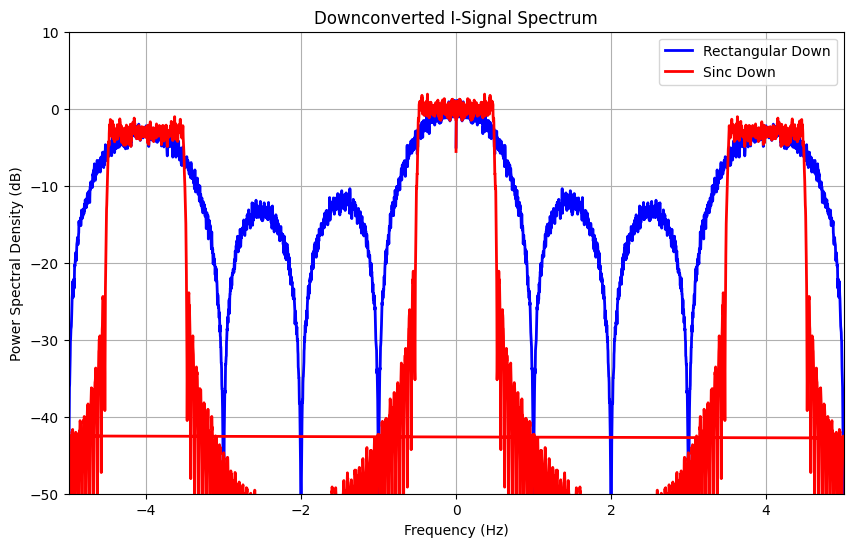

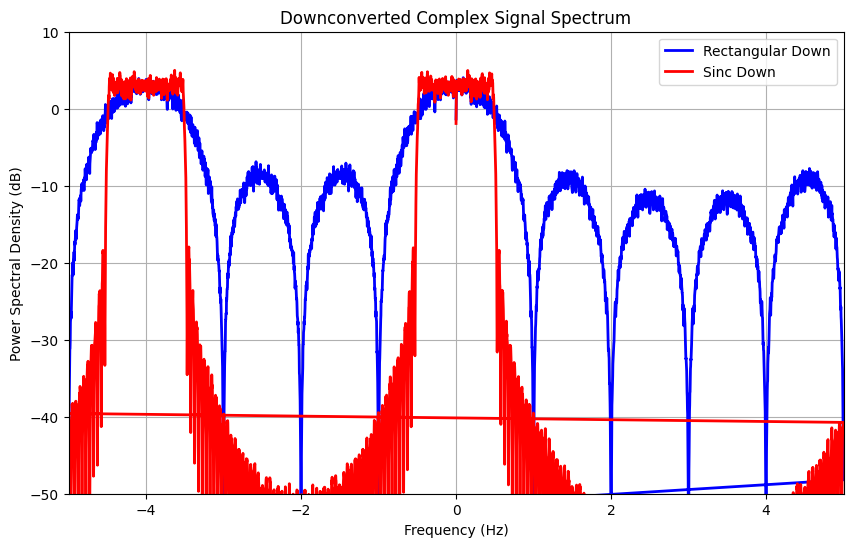

In [91]:
# Downconversion
# Downconvert rectangular pulse shaped signal
down_i_rect = 1 * s_rectangular * cos_carrier_rectangular
down_q_rect = -1 * s_rectangular * sin_carrier_rectangular

# Downconvert sinc pulse shaped signal
down_i_sinc = 1 * s_sinc * cos_carrier_sinc
down_q_sinc = -1 * s_sinc * sin_carrier_sinc

# Plot downconverted spectrum
f_down_rect_i, Pxx_down_rect_i = welch(down_i_rect, fs=fs, nperseg=4096, return_onesided=False)
f_down_sinc_i, Pxx_down_sinc_i = welch(down_i_sinc, fs=fs, nperseg=4096, return_onesided=False)

plt.figure(figsize=(10, 6))
plt.plot(f_down_rect_i, 10 * np.log10(Pxx_down_rect_i), 'b-', label='Rectangular Down', linewidth=2)
plt.plot(f_down_sinc_i, 10 * np.log10(Pxx_down_sinc_i), 'r-', label='Sinc Down', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Downconverted I-Signal Spectrum')
plt.legend()
plt.grid(True)
plt.xlim([-5, 5])
plt.ylim([-50, 10])
plt.show()

# Create complex signals from downconverted I and Q
down_complex_rect = down_i_rect + 1j * down_q_rect
down_complex_sinc = down_i_sinc + 1j * down_q_sinc

# Plot downconverted complex spectrum
f_down_rect, Pxx_down_rect = welch(down_complex_rect, fs=fs, nperseg=4096, return_onesided=False)
f_down_sinc, Pxx_down_sinc = welch(down_complex_sinc, fs=fs, nperseg=4096, return_onesided=False)

plt.figure(figsize=(10, 6))
plt.plot(f_down_rect, 10 * np.log10(Pxx_down_rect), 'b-', label='Rectangular Down', linewidth=2)
plt.plot(f_down_sinc, 10 * np.log10(Pxx_down_sinc), 'r-', label='Sinc Down', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Downconverted Complex Signal Spectrum')
plt.legend()
plt.grid(True)
plt.xlim([-5, 5])
plt.ylim([-50, 10])
plt.show()

### Lowpass filtering

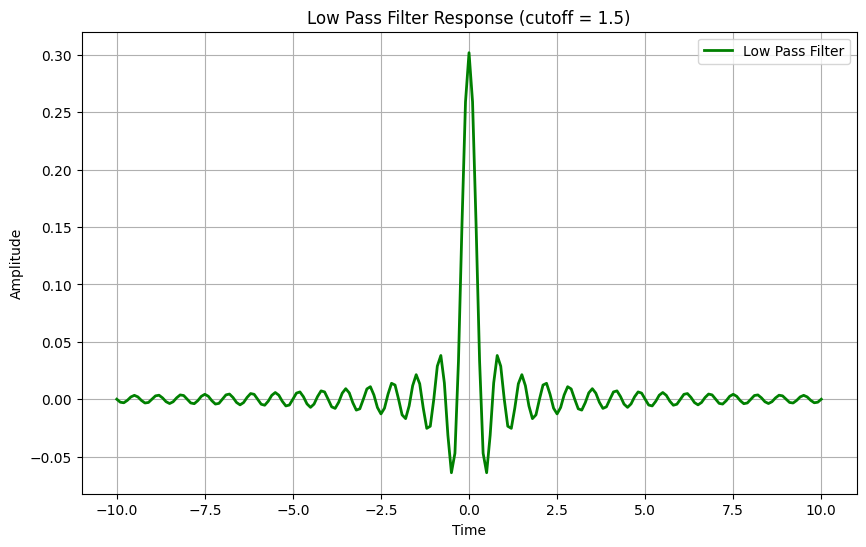

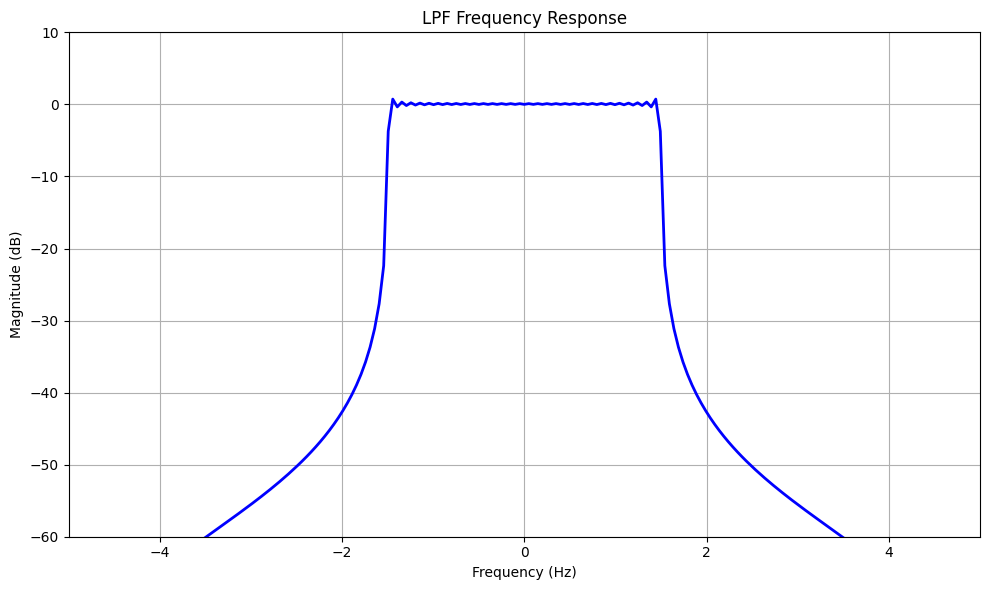

In [ ]:
# Low pass filter design
# Cut-off frequency at 1.5 (between baseband and 2fc)
cutoff = 1.5
t_lpf = np.arange(-fs, fs + 1/fs, 1/fs)
h_lpf = 2 * cutoff * np.sinc(2 * cutoff * t_lpf)  # Ideal low pass filter

# Normalize filter response
h_lpf = h_lpf / np.sum(h_lpf)  # Normalize to unit DC gain

# Plot LPF response
plt.figure(figsize=(10, 6))
plt.plot(t_lpf, h_lpf, 'g-', linewidth=2, label='Low Pass Filter')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Low Pass Filter Response (cutoff = 1.5)')
plt.grid(True)
plt.legend()
plt.show()


# Calculate and plot frequency response
f_response = np.fft.fftshift(np.fft.fft(h_lpf))
f = np.fft.fftshift(np.fft.fftfreq(len(h_lpf), 1/fs))
plt.figure(figsize=(10, 6))
plt.plot(f, 20 * np.log10(np.abs(f_response)), 'b-', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('LPF Frequency Response')
plt.grid(True)
plt.xlim([-5, 5])
plt.ylim([-60, 10])
plt.tight_layout()
plt.show()



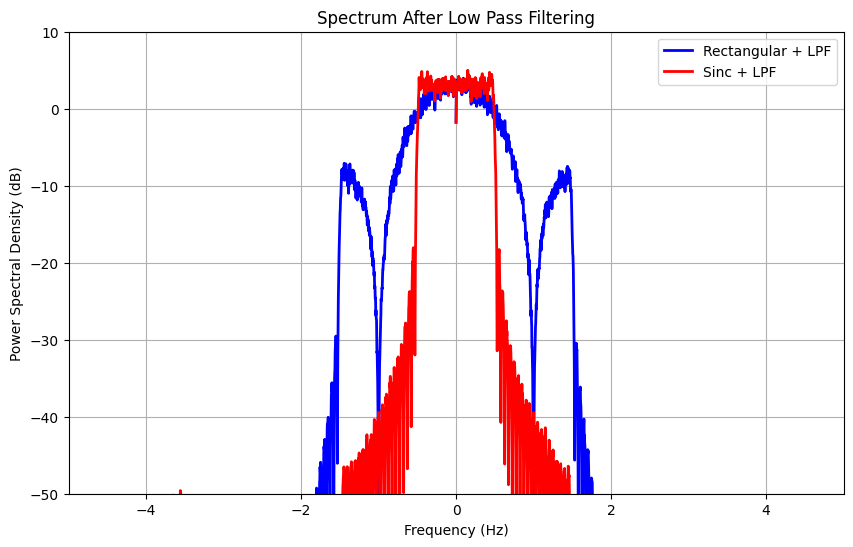

In [96]:

# Apply LPF to downconverted signals
# For rectangular pulse shaped signal
lpf_i_rect = convolve(down_i_rect, h_lpf, mode='full')
lpf_q_rect = convolve(down_q_rect, h_lpf, mode='full')

# For sinc pulse shaped signal
lpf_i_sinc = convolve(down_i_sinc, h_lpf, mode='full')
lpf_q_sinc = convolve(down_q_sinc, h_lpf, mode='full')

# Create complex signals after LPF
lpf_complex_rect = lpf_i_rect + 1j * lpf_q_rect
lpf_complex_sinc = lpf_i_sinc + 1j * lpf_q_sinc

# Plot spectrum after LPF
f_lpf_rect, Pxx_lpf_rect = welch(lpf_complex_rect, fs=fs, nperseg=4096, return_onesided=False)
f_lpf_sinc, Pxx_lpf_sinc = welch(lpf_complex_sinc, fs=fs, nperseg=4096, return_onesided=False)

plt.figure(figsize=(10, 6))
plt.plot(f_lpf_rect, 10 * np.log10(Pxx_lpf_rect), 'b-', label='Rectangular + LPF', linewidth=2)
plt.plot(f_lpf_sinc, 10 * np.log10(Pxx_lpf_sinc), 'r-', label='Sinc + LPF', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Spectrum After Low Pass Filtering')
plt.legend()
plt.grid(True)
plt.xlim([-5, 5])
plt.ylim([-50, 10])
plt.show()


### Matched filtering

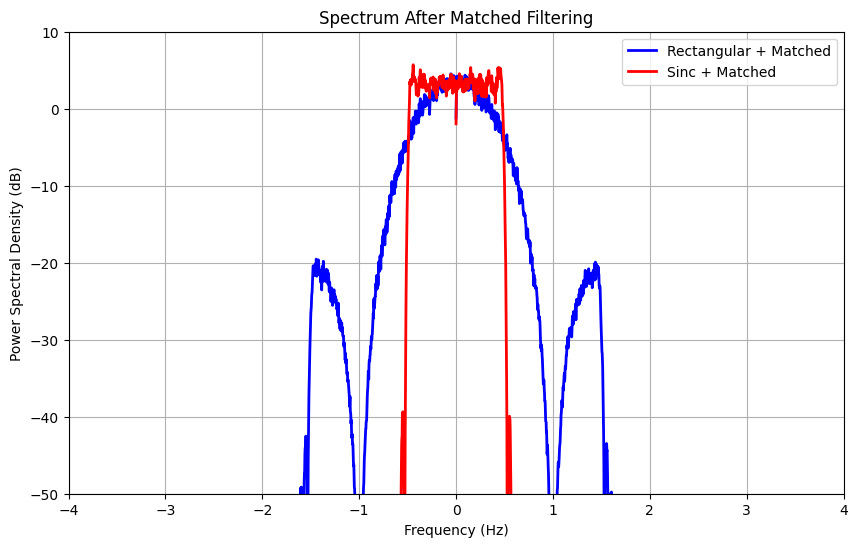

In [94]:
# Matched filtering
# Create matched filters (time reversed conjugate of pulse shaping filters)
gt_rectangular_matched = np.flip(gt_rectangular).conj()
gt_sinc_matched = np.flip(gt_sinc).conj()

gt_rectangular_lpf = np.convolve(gt_rectangular, h_lpf, mode='full')
gt_rectangular_lpf_matched = np.convolve(gt_rectangular_lpf,gt_rectangular_matched)

# Normalize matched filters
# For rectangular filter - normalize by number of samples
gt_rectangular_matched = gt_rectangular_matched/np.max(gt_rectangular_lpf_matched)

# For sinc filter - normalize by energy
gt_sinc_matched = gt_sinc_matched / np.sum(gt_sinc_matched)

# Apply matched filters to downconverted and LPF signals
# For rectangular pulse shaped signal
match_i_rect = convolve(lpf_i_rect, gt_rectangular_matched, mode='full')
match_q_rect = convolve(lpf_q_rect, gt_rectangular_matched, mode='full')

# For sinc pulse shaped signal
match_i_sinc = convolve(lpf_i_sinc, gt_sinc_matched, mode='full')
match_q_sinc = convolve(lpf_q_sinc, gt_sinc_matched, mode='full')

# Create complex signals after matched filtering
match_complex_rect = match_i_rect + 1j * match_q_rect
match_complex_sinc = match_i_sinc + 1j * match_q_sinc

# Plot spectrum after matched filtering
f_match_rect, Pxx_match_rect = welch(match_complex_rect, fs=fs, nperseg=4096, return_onesided=False)
f_match_sinc, Pxx_match_sinc = welch(match_complex_sinc, fs=fs, nperseg=4096, return_onesided=False)

plt.figure(figsize=(10, 6))
plt.plot(f_match_rect, 10 * np.log10(Pxx_match_rect), 'b-', label='Rectangular + Matched', linewidth=2)
plt.plot(f_match_sinc, 10 * np.log10(Pxx_match_sinc), 'r-', label='Sinc + Matched', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Spectrum After Matched Filtering')
plt.legend()
plt.grid(True)
plt.xlim([-4, 4])
plt.ylim([-50, 10])
plt.show()

# For symbol recovery, use these matched filtered signals instead of the previous ones
# Updated variable names from demod_filtered to match_filtered
match_filtered_complex_rect = match_complex_rect
match_filtered_complex_sinc = match_complex_sinc

### Received symbol vs transmit symbol (and error)

MSE (Rectangular): 9.855e-03 (-20.1 dB)
MSE (Sinc): 2.396e-02 (-16.2 dB)


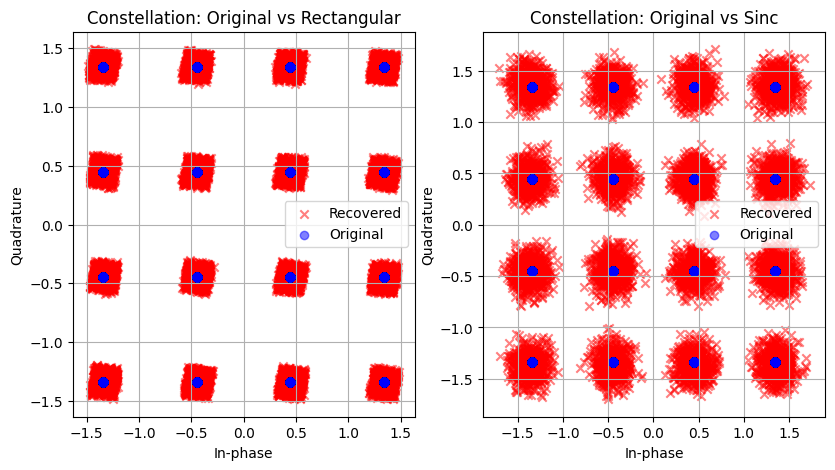

In [98]:
# Compare original and recovered signals
original_complex = am_i + 1j * am_q

# Calculate total delay for proper symbol timing
# Delays: LPF delay + matched filter delay
rect_total_delay = int(fs*fs + fs -1)  # LPF delay + rectangular matched filter delay
sinc_total_delay = int(3*fs*fs)  # LPF delay + sinc matched filter delay

# Extract symbols at correct timing
recovered_rect = match_filtered_complex_rect[rect_total_delay::fs][:N]
recovered_sinc = match_filtered_complex_sinc[sinc_total_delay::fs][:N]

# Calculate error metrics
mse_rect = np.mean(np.abs(original_complex - recovered_rect)**2)
mse_sinc = np.mean(np.abs(original_complex - recovered_sinc)**2)

# Calculate error in dB
error_db_rect = 10 * np.log10(mse_rect)
error_db_sinc = 10 * np.log10(mse_sinc)


print(f"MSE (Rectangular): {mse_rect:.3e} ({error_db_rect:.1f} dB)")
print(f"MSE (Sinc): {mse_sinc:.3e} ({error_db_sinc:.1f} dB)")

# Plot constellation diagrams
plt.figure(figsize=(15, 5))

# Original vs Recovered (Rectangular)
plt.subplot(131)
plt.scatter(recovered_rect.real, recovered_rect.imag, 
           c='red', label='Recovered', alpha=0.5, marker='x')
plt.scatter(original_complex.real, original_complex.imag, 
           c='blue', label='Original', alpha=0.5, marker='o')
plt.title('Constellation: Original vs Rectangular')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.legend()

# Original vs Recovered (Sinc)
plt.subplot(132)
plt.scatter(recovered_sinc.real, recovered_sinc.imag, 
           c='red', label='Recovered', alpha=0.5, marker='x')
plt.scatter(original_complex.real, original_complex.imag, 
           c='blue', label='Original', alpha=0.5, marker='o')
plt.title('Constellation: Original vs Sinc')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.legend()
